In [15]:
import os

base_dir = "/storage"
base_dir_7t = [base_dir + "/HCP_7T/" + i   for i in os.listdir(base_dir + "/HCP_7T") if len(i) == 6]
base_dir_3t = [base_dir + "/HCP_3T/" + i   for i in os.listdir(base_dir + "/HCP_3T") if len(i) == 6]

path_7t = {}
path_3t = {}



for i in base_dir_7t:
    path_7t[i[-6:]] = {"3d_scan" : i + "/T1w/T1w_acpc_dc_restore_1.05.nii.gz" ,"data" : i + "/T1w/Diffusion_7T/data.nii.gz" 
                       , "bvals" : i + "/T1w/Diffusion_7T/bvals" , "bvecs" : i + "/T1w/Diffusion_7T/bvecs"
                      , "brain_mask" : i + "/T1w/Diffusion_7T/nodif_brain_mask.nii.gz"
                      , "grad_dev" : i + "/T1w/Diffusion_7T/grad_dev.nii.gz"}
for i in base_dir_3t:
    path_3t[i[-6:]] = {"3d_scan" : i + "/T1w/T1w_acpc_dc_restore_1.25.nii.gz" , "data" : i + "/T1w/Diffusion/data.nii.gz" 
                       , "bvals" : i + "/T1w/Diffusion/bvals" , "bvecs" : i + "/T1w/Diffusion/bvecs"
                       , "brain_mask" : i + "/T1w/Diffusion/nodif_brain_mask.nii.gz"
                      , "grad_dev" : i + "/T1w/Diffusion/grad_dev.nii.gz"}
    
    
path = {'3T': path_3t, "7T": path_7t}
p = list(path_7t.keys())
q = list(path_3t.keys())
common = list(set(p) & set(q))
common.sort()
print("number of common Subjects ",len(common))

def get_ids():
    return common

def load_hcp(id_load,res,crop = 1):
    load_from = path[res][id_load]
    data , affine = load_nifti(load_from["data"])
    mask,affine = load_nifti(load_from["brain_mask"])
    
    bvals, bvecs = read_bvals_bvecs(load_from['bvals'], load_from['bvecs'])
    gtab = gradient_table(bvals, bvecs)
    
    return data[:,:,crop:-crop,:],mask[:,:,crop:-crop],gtab

def load_gtab(id_load,res):
    load_from = path[res][id_load]
    bvals, bvecs = read_bvals_bvecs(load_from['bvals'], load_from['bvecs'])
    gtab = gradient_table(bvals, bvecs)
    return gtab

number of common Subjects  171


In [2]:
from dipy.io.image import load_nifti
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import numpy as np
import os
import matplotlib.pyplot as plt
from numpy.linalg import eig
from numpy.linalg import inv
from numpy.linalg import pinv
# from numpy.linalg import lstsq
from scipy.linalg import lstsq
from numpy.linalg import solve
from numpy import inf
import numpy as np

import SimpleITK as sitk


dsm = np.array([0.91, 0.416, 0,0, 0.91, 0.416,0.416, 0, 0.91,0.91, -0.416, 0,0, 0.91, -0.416,-0.416, 0, 0.91])
dsm = dsm.reshape(6,3)
dsm_norm = np.copy(dsm)
dsm_mag = np.sqrt(dsm[:,0]**2 + dsm[:,1]**2 + dsm[:,2]**2)
for i in range(3):
    dsm_norm[:,i] = dsm[:,i] / dsm_mag

def rot3d(arg):
    x,y,z = arg[0],arg[1],arg[2]
    Rx = np.array([[1 ,0 ,0 ],[0,np.cos(x),-np.sin(x)],[0 ,np.sin(x) ,np.cos(x)]])
    Ry = np.array([[np.cos(y),0 ,np.sin(y) ],[0,1,0],[-np.sin(y),0,np.cos(y)]])
    Rz = np.array([[np.cos(z) ,-np.sin(z) ,0 ],[np.sin(z),np.cos(z),0],[0 ,0,1]])
    R = Rx @ Ry @ Rz
    return R

def amatrix(mat):
    
    a = [mat[:,0] * mat[:,0],2 * mat[:,0] * mat[:,1], 2* mat[:,0] * mat[:,2],
        mat[:,1] * mat[:,1],2 * mat[:,1] * mat[:,2], mat[:,2] * mat[:,2]]
    return np.array(a).T

def optimal_dirs(gtab,num_iter,num_dirs,debug = False,base_bval = 5):
    rotang_all = []
    angerr_all  = []
    condnum_all = []
    ind_all = []
    dirs = np.array(gtab.bvecs[np.where(gtab.bvals != base_bval)[0]])
    for i in range(0,num_iter):
        
        d = np.random.rand(1,3) * 2 * np.pi
        rotang = d[0]
        R = rot3d(rotang)
        dsm_rot = (rot3d(d[0]) @ dsm_norm.T).T
        
        ang_error = np.degrees(np.arccos(abs(dsm_rot @ dirs.T)))
        minerrors,idx = np.amin(ang_error,1),np.argmin(ang_error,1)

        mean_ang_err = np.mean(np.amin(ang_error,1))
        condnum = np.linalg.cond(amatrix(dirs[idx]))
        
        idx.sort()
        if (mean_ang_err < 5 and condnum < 1.6):
            if ((len(ind_all) == 0 ) or  len(np.where((ind_all == idx).all(axis=1))[0]) == 0 ):
                angerr_all.append(mean_ang_err)
                condnum_all.append(condnum)
                ind_all.append(idx)
                rotang_all.append(rotang)
    condnum_all = np.array(condnum_all)
    indx  = condnum_all.argsort()[:num_dirs]
    if (debug):
        print("Lowest Condition Number : ",condnum_all[indx])
    ind_use = np.array(ind_all)[indx]
    condnum_use = condnum_all[condnum_all.argsort()[:5]]
    angerr_use = np.array(angerr_all)[indx]
    rotang_use = np.array(rotang_all)[indx]
    return ind_use,condnum_all[indx]
# import numpy as np
def resample_img(itk_image, out_spacing,sampler = 'bspline'):
    
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    if sampler == 'bspline':
        resample.SetInterpolator(sitk.sitkBSpline)
    elif sampler == 'nearneighbour':
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkLinear)

    return resample.Execute(itk_image)

def resampler(data_sitk,idx,b0):
    resampled_sitk_img = []
    resampled_img = resample_img(data_sitk[:,:,:,int(b0)], out_spacing=[1.05,1.05, 1.05],sampler = 'linear')
    resampled_sitk_img.append(sitk.GetArrayFromImage(resampled_img))
    for i in idx:
        resampled_img = resample_img(data_sitk[:,:,:,int(i)], out_spacing=[1.05,1.05, 1.05],sampler = 'linear')
        resampled_sitk_img.append(sitk.GetArrayFromImage(resampled_img))
    return np.stack(resampled_sitk_img, axis=3)

In [3]:
from dipy.segment.mask import median_otsu
from dipy.reconst.dti import fractional_anisotropy, color_fa
import dipy.reconst.dti as dti
import h5py

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
shape_file_7t = {}

In [33]:
limited_common = common[:40]

In [34]:
shape_file = {}

In [35]:
data_sitk = sitk.ReadImage(path['3T']['100610']['data'])

In [45]:
mask_sitk = sitk.ReadImage(path['3T']['100610']['brain_mask'])

In [46]:
mask_sitk.GetSize()

(145, 174, 145)

In [47]:
mask = resample_img(mask_sitk, out_spacing=[1.05,1.05, 1.05],sampler = 'linear')

In [49]:
mask.GetSize()

(173, 207, 173)

In [ ]:
for i in limited_common:
    print("Current ID",i)
#     data,mask,gtab = load_hcp(i,'3T')brain_mask
    gtab = load_gtab(i,'3T')
    data_sitk = sitk.ReadImage(path['3T'][i]['data'])
    mask_sitk = sitk.ReadImage(path['3T'][i]['brain_mask'])
    name = "/storage/HCP_3T/" + i + "/" + i + "_upsampled.h5"
#     shape_file[i] = data_sitk.GetSize()
    hf = h5py.File(name, 'w')
#     temp = data[:,:,:,gtab.bvals>5]
    idx,cond= optimal_dirs(gtab,10000,5,debug = True,base_bval = int(min(gtab.bvals)))
    idx = np.where(gtab.bvals>int(min(gtab.bvals)))[0][idx]
#     dw_bvals = gtab.bvecs[gtab.bvals!=int(min(gtab.bvals)),:],gtab.bvals[gtab.bvals!=int(min(gtab.bvals))]
    
    for j in range(3):
        sample = np.random.randint(0,len(np.where(gtab.bvals==int(min(gtab.bvals)))[0]))
        sample = np.where(gtab.bvals==int(min(gtab.bvals)))[0][sample]
#         b0 = data[:,:,:,sample]
        bvals6 = np.insert(gtab.bvals[idx[j]],0,gtab.bvals[sample])
        bvecs6 = np.insert(gtab.bvecs[idx[j]],0,gtab.bvecs[sample],axis = 0)
#         data6 = temp[:,:,:,idx[j]]
#         data6 = np.insert(data6,0,b0,axis =3)
        
        data6 = resampler(data_sitk,idx[j],sample)
        hf.create_dataset('volumes'+ str(j), data=data6)
        hf.create_dataset('bvals'+ str(j), data=bvals6)
        hf.create_dataset('bvecs'+ str(j), data=bvecs6)
    hf.create_dataset('idx', data=idx)
    hf.create_dataset('cond', data=cond)
    mask = resample_img(mask_sitk, out_spacing=[1.05,1.05, 1.05],sampler = 'linear')
    hf.create_dataset('mask', data=sitk.GetArrayFromImage(mask))
    
    hf.close()
    
    print(name,"Done")
    
#     name = "/storage/HCP_3T/" + i + "/" + i + "_GT.h5"
#     hf = h5py.File(name, 'w')
    
#     tenmodel = dti.TensorModel(gtab)
#     tenfit = tenmodel.fit(data,mask=mask)
#     tensor_vals = dti.lower_triangular(tenfit.quadratic_form)
#     FA = fractional_anisotropy(tenfit.evals)
#     MD = dti.mean_diffusivity(tenfit.evals)
#     FA[np.isnan(FA)] = 0
#     FA = np.clip(FA, 0, 1)
#     RGB = color_fa(FA, tenfit.evecs)
    
#     hf.create_dataset('tensor_vals', data=tensor_vals)
#     hf.create_dataset('ADC', data=MD)
#     hf.create_dataset('FA', data=FA)
#     hf.create_dataset('color_FA', data=RGB)
    
#     hf.close()
#     print(name,"Done")

    break

Current ID 100610


In [51]:
hf.close()

In [ ]:
for i in limited_common:
    print("Current ID",i)
    data,mask,gtab = load_hcp(i,'7T')
    name = "/storage/HCP_7T/" + i + "/" + i + ".h5"
    shape_file_7t[i] = data.shape
    hf = h5py.File(name, 'w')
    temp = data[:,:,:,gtab.bvals>5]
    idx,cond= optimal_dirs(gtab,10000,5,debug = True,base_bval = int(min(gtab.bvals)))
    base_bvals_vols = data[:,:,:,gtab.bvals==int(min(gtab.bvals))]
    base_bvals = gtab.bvecs[gtab.bvals==int(min(gtab.bvals)),:],gtab.bvals[gtab.bvals==int(min(gtab.bvals))]
    dw_bvals = gtab.bvecs[gtab.bvals!=int(min(gtab.bvals)),:],gtab.bvals[gtab.bvals!=int(min(gtab.bvals))]
    for j in range(3):
        sample = np.random.randint(0,base_bvals_vols.shape[3])
        b0 = base_bvals_vols[:,:,:,sample]
        bvals6 = np.insert(dw_bvals[1][idx[j]],0,base_bvals[1][sample])
        bvecs6 = np.insert(dw_bvals[0][idx[j]],0,base_bvals[0][sample],axis = 0)
        data6 = temp[:,:,:,idx[j]]
        data6 = np.insert(data6,0,b0,axis =3)
        hf.create_dataset('volumes'+ str(j), data=data6)
        hf.create_dataset('bvals'+ str(j), data=bvals6)
        hf.create_dataset('bvecs'+ str(j), data=bvecs6)
    hf.create_dataset('idx', data=idx)
    hf.create_dataset('cond', data=cond)
    hf.create_dataset('mask', data=mask)
    
    hf.close()
    print(name,"Done")
    
    name = "/storage/HCP_7T/" + i + "/" + i + "_GT.h5"
    hf = h5py.File(name, 'w')
    
    tenmodel = dti.TensorModel(gtab)
    tenfit = tenmodel.fit(data,mask=mask)
    tensor_vals = dti.lower_triangular(tenfit.quadratic_form)
    FA = fractional_anisotropy(tenfit.evals)
    MD = dti.mean_diffusivity(tenfit.evals)
    FA[np.isnan(FA)] = 0
    FA = np.clip(FA, 0, 1)
    RGB = color_fa(FA, tenfit.evecs)
    
    hf.create_dataset('tensor_vals', data=tensor_vals)
    hf.create_dataset('ADC', data=MD)
    hf.create_dataset('FA', data=FA)
    hf.create_dataset('color_FA', data=RGB)
    
    hf.close()
    print(name,"Done")

In [ ]:
shape_file

In [ ]:
shape_file_7t

In [ ]:
lr = (145, 174, 143, 288)
hr = (173, 207, 171, 143)

In [ ]:
for i in range(3):
    print(hr[i]/lr[i],end=" ")

In [ ]:
%who

In [ ]:
common[0]

In [ ]:
data,mask,gtab = load_hcp(common[0],'3T')

In [ ]:
idx = optimal_dirs(gtab,10000,5,debug = True,base_bval = 5)

In [ ]:
gtab.bvals[idx[0]],gtab.bvecs[idx[0]]

In [ ]:
bvals6,bvecs6 = np.insert(gtab.bvals[idx[0]],0,gtab.bvals[0]),np.insert(gtab.bvecs[idx[0]],0,gtab.bvecs[0],axis = 0)

In [ ]:
bvals6,bvecs6

In [ ]:
len(bvals6),len(bvecs6)

In [ ]:
gtab6 = gradient_table(bvals6, bvecs6)

In [ ]:
temp = data[:,:,:,gtab.bvals>5]

In [ ]:
data6 = temp[:,:,:,idx[0]]

In [ ]:
data6.shape

In [ ]:
data6 = np.insert(data6,0,data[:,:,:,0],axis =3)

In [ ]:
data6.shape

In [ ]:
import h5py
name = "/storage/HCP_3T/" + common[0] + "/" + common[0] + ".h5"

In [ ]:
name

In [ ]:

hf = h5py.File(name, 'w')

In [ ]:
hf.create_dataset('volumes', data=data6)
hf.create_dataset('bvals', data=bvals6)
hf.create_dataset('bvecs', data=bvecs6)

In [ ]:
hf.close()

In [ ]:
name = "/storage/HCP_3T/" + common[0] + "/" + common[0] + ".h5"
hf = h5py.File(name, 'r')

In [ ]:
list(hf.keys())

In [ ]:
for i in list(hf.keys())[3:6]:
    print(i,np.array(hf.get(i)))

In [ ]:
plt.imshow(np.array(hf.get('mask'))[:,:,50])
plt.axline((14, 15), (14, 128), linewidth=4, color='r')
plt.axline((163, 15), (163, 128), linewidth=4, color='r')

In [ ]:
xind,yind,zind = np.nonzero(np.array(hf.get('mask')))

In [ ]:
xmin,xmax = np.min(xind),np.max(xind)
ymin,ymax = np.min(yind),np.max(yind)
zmin,zmax = np.min(zind),np.max(zind)

ind_brain = [xmin, xmax, ymin, ymax, zmin, zmax]

In [ ]:
def extract_block(data, inds):

        xsz_block = inds[0, 1] - inds[0, 0] + 1
        ysz_block = inds[0, 3] - inds[0, 2] + 1
        zsz_block = inds[0, 5] - inds[0, 4] + 1
        ch_block = data.shape[-1]
        
        blocks = []
        
        for ii in np.arange(inds.shape[0]):
            inds_this = inds[ii, :]
            curr_blk = data[inds_this[0]:inds_this[1]+1, inds_this[2]:inds_this[3]+1, inds_this[4]:inds_this[5]+1, :]
            if(np.count_nonzero(curr_blk)/curr_blk.size >0.6):
                blocks.append(curr_blk)
        return np.stack(blocks, axis=0)
    
def blocks(base_mask):
        # %% divide brain volume to blocks
        xind,yind,zind = np.nonzero(base_mask)
        xmin,xmax = np.min(xind),np.max(xind)
        ymin,ymax = np.min(yind),np.max(yind)
        zmin,zmax = np.min(zind),np.max(zind)

        ind_brain = [xmin, xmax, ymin, ymax, zmin, zmax] 
        # print(ind_brain)
        # calculate number of blocks along each dimension
        xlen = xmax - xmin + 1
        ylen = ymax - ymin + 1
        zlen = zmax - zmin + 1
        blk_size = (64,64,64)
        nx = int(np.ceil(xlen / blk_size[0]))
        ny = int(np.ceil(ylen / blk_size[1]))
        nz = int(np.ceil(zlen / blk_size[2]))

        # determine starting and ending indices of each block
        xstart = xmin
        ystart = ymin
        zstart = zmin

        xend = xmax - blk_size[0] + 1
        yend = ymax - blk_size[1] + 1
        zend = zmax - blk_size[2] + 1

        xind_block = np.round(np.linspace(xstart, xend, nx))
        yind_block = np.round(np.linspace(ystart, yend, ny))
        zind_block = np.round(np.linspace(zstart, zend, nz))

        ind_block = np.zeros([xind_block.shape[0]*yind_block.shape[0]*zind_block.shape[0], 6])
        count = 0
        for ii in np.arange(0, xind_block.shape[0]):
            for jj in np.arange(0, yind_block.shape[0]):
                for kk in np.arange(0, zind_block.shape[0]):
                    ind_block[count, :] = np.array([xind_block[ii], xind_block[ii]+blk_size[0]-1, yind_block[jj], yind_block[jj]+blk_size[1]-1, zind_block[kk], zind_block[kk]+blk_size[2]-1])
                    count = count + 1

        ind_block = ind_block.astype(int)
        # print(ind_block)
        return ind_block,len(ind_block)

In [ ]:
mask = np.array(hf.get('mask'))

In [ ]:
inds,tot = blocks(mask)

In [ ]:
inds.shape

In [ ]:
img = np.array(hf.get('volumes0'))
imgmean = np.mean(img[np.nonzero(np.array(hf.get('mask')))])
imgstd = np.std(img[np.nonzero(np.array(hf.get('mask')))])

In [ ]:
img_norm = (img-np.min(img))/(np.max(img)-np.min(img))

In [ ]:
img_norm.max(),img_norm.min()

In [ ]:
img.shape

In [ ]:
img.shape,mask.shape

In [ ]:
temp = np.concatenate((img,mask),axis =3)

In [ ]:
temp.shape

In [ ]:
plt.imshow(temp[:,:,20,7])

In [ ]:
img.max(),img.min()

In [ ]:
temp = extract_block(np.array(hf.get('volumes0')),inds)

In [ ]:
temp.shape

In [ ]:
temp[0].shape

In [ ]:
plt.imshow(temp[5,:,:,10,0]),temp[5,:,:,10,0].min(),temp[5,:,:,10,0].max()

In [ ]:
temp = extract_block(img_norm,inds)

In [ ]:
temp.shape

In [ ]:
plt.imshow(temp[5,:,:,10,0]),temp[5,:,:,10,0].min(),temp[5,:,:,10,0].max()

In [ ]:
temp[100,:,:,10,0].size

In [ ]:
np.count_nonzero(temp[60,:,:,10,0])/temp[60,:,:,10,0].size

In [ ]:
temp[200,:,:,:,:].shape

In [ ]:
blocks = []

In [ ]:
blocks.shape

In [ ]:
blocks = np.concatenate((blocks,temp[200,:,:,:,:]),axis = 0)

In [ ]:
blocks.shape

In [ ]:
np.array(hf.get('volumes0')).shape

In [ ]:
for i in list(hf.keys())[:3]:
    print(i,np.array(hf.get(i)))

In [ ]:
np.array(hf.get('cond'))

In [ ]:
np.array(hf.get('idx'))

In [ ]:
for i in list(hf.keys()):
    print(i,np.array(hf.get(i)).shape)

In [ ]:
hf.close()

In [ ]:
common[0]

In [38]:
name = "/storage/HCP_3T/" + common[0] + "/" + common[0] + "_upsampled.h5"
hf = h5py.File(name, 'r')

In [ ]:
np.array(hf.get(i)).shape

In [40]:
np.array(hf.get('bvals1'))

array([   5.,  990., 1000.,  990., 1005., 1000., 1995.])

In [41]:
np.array(hf.get('bvals2'))

array([   5., 2985., 1000., 1005., 1000., 2985., 1995.])

In [42]:
np.array(hf.get('bvals0'))

array([   5.,  990., 1000., 1005., 1000., 2985., 1995.])

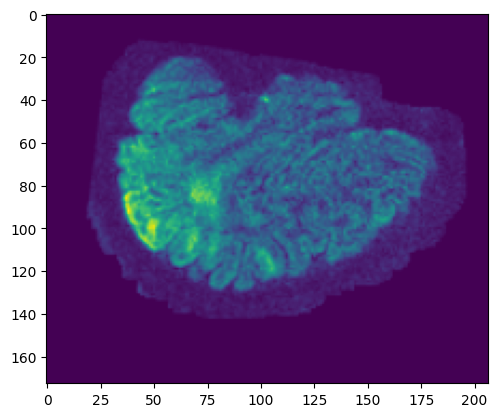

In [43]:
plt.imshow(np.array(hf.get('volumes0'))[:,:,50,6])

In [39]:
for i in list(hf.keys()):
    print(i,np.array(hf.get(i)).shape)

bvals0 (7,)
bvals1 (7,)
bvals2 (7,)
bvecs0 (7, 3)
bvecs1 (7, 3)
bvecs2 (7, 3)
cond (5,)
idx (5, 6)
mask (6195303,)
volumes0 (173, 207, 173, 7)
volumes1 (173, 207, 173, 7)
volumes2 (173, 207, 173, 7)


In [ ]:
np.array(hf.get('ADC')).max(),np.array(hf.get('ADC')).min()

In [ ]:
np.array(hf.get('FA')).max(),np.array(hf.get('FA')).min()

In [ ]:
np.array(hf.get('color_FA')).max(),np.array(hf.get('color_FA')).min()

In [ ]:
np.array(hf.get('ADC'))

In [ ]:
i=70
f, axis = plt.subplots(1, 3)
f.set_figwidth(20)
f.set_figheight(10)
axis[0].set_title('FA "fractional anisotropy"')
axis[0].imshow(np.array(hf.get('FA'))[:,:,i])
axis[1].set_title('MD "Mean Diffusivity or Average Diffusion Coefficent(ADC)"')
axis[1].imshow(np.array(hf.get('ADC'))[:,:,i])
axis[2].set_title('MD_RGB "Principal Diffusion Directions"')
axis[2].imshow(np.array(hf.get('color_FA'))[:,:,i])